# STR Selection Simulation

## Key parameters:
* mu: per-generation mutation rate
* beta: length constraint
* p: step size parameter (geometric distribution)
* S: selection coefficient. Most fit allele has relative fitness 1. Next most has 1-s, next most has 1-2s, etc.
* num_alleles: Size of transition matrix to build. Centered at "0" (most optimal allele in the center)
* L: length-dependent mutation rate where muprime=mu+L(al), where mu is mean mutation rate (for allele 0)

In [1]:
# STR Selection Simulation without avoiding 0's in the various matrices (mutation, covariance, genotype fitness)

########## Function definitions and imports ##########

%pylab inline
import numpy as np
from scipy.stats import geom
import copy

# Geometric step size prob
def GetStepSizeProb(a1, a2, beta, p):
    step_size = (a2-a1)
    if abs(step_size)>10: return 0 # TODO limit? (There is a zero percent chance that a STR will expand/contract more than a certain step size)
    up_prob = max([0,0.5*(1-beta*p*a1)])
    down_prob = 1-up_prob
    if step_size>0: dir_prob = up_prob
    else: dir_prob = down_prob
    step_prob = geom.pmf(abs(step_size), p)
    return dir_prob*step_prob

### Main function to build transition matrix ###
def GetTransitionMatrix(num_alleles, mu, beta, p, L=0):
    # Initialize matrix (optimal=0)
    transition_matrix = np.zeros((num_alleles, num_alleles))

    # Fill in probability to transition from a1 to a2
    for i in range(num_alleles):
        for j in range(num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
            mu_prime = mu+L*a1 # Length-dependent mutation rate. TODO should we do a sigmoid curve like Payseur?
            if mu_prime < 0: mu_prime = 0
            if mu_prime > 1: mu_prime = 1
            if a1==a2: transition_matrix[i,j] = 1-mu_prime
            else:
                prob = GetStepSizeProb(a1, a2, beta, p)
                transition_matrix[i,j] = mu_prime*prob
        
    # Rescale each row to sum to 1 (which should hopefully be mostly true anyway)
    for i in range(num_alleles):
        rowsum = np.sum(transition_matrix[i,:])
        transition_matrix[i,:] = transition_matrix[i,:]/rowsum

    return transition_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
########## More function definitions ##########
### Build covariance matrix ###
# TODO minor point, don't need to take in num_alleles, since it is just len(allele_freqs)
# Similar comment for other functions below
def GetCovarianceMatrix(num_alleles, allele_freqs):
    # Initialize matrix 
    covariance_matrix = np.zeros((num_alleles, num_alleles))
    
    # Fill in diagonal elements C[i,i] = p[i](1-p[i])/2 (division by 2 not included here)
    for i in range (0, num_alleles):
        covariance_matrix[i,i] = allele_freqs[i]*(1-allele_freqs[i])
        
    # Fill in off-diagonal elements C[i,j] = -p[i]p[j]/2 (divison by 2 not included here)
    for i in range(0, num_alleles):
        for j in range(0, num_alleles):
            if i != j:
                covariance_matrix[i,j] = -1*allele_freqs[i]*allele_freqs[j]
                
    return covariance_matrix

### Build fitness matrix (fitness of each genotype) ###
# TODO minor point, conflict between NUM_ALLELES and num_alleles
def GetFitnessMatrix(num_alleles, S, is_w_additive):
    fitness_matrix = np.zeros((NUM_ALLELES, NUM_ALLELES))
    for i in range (0, num_alleles):
        for j in range (0, num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
            
            # TODO: maybe the max should be applied at the genotype level rather than allele level?
            # Get fitness of each allele, w cannot be less than 0
            w_a1 = max(0, 1-abs(a1)*S) #np.exp(-1*abs(a1)*S) Chance allele won't die, higher w = higher fitness
            w_a2 = max(0, 1-abs(a2)*S) #np.exp(-1*abs(a2)*S) Chance allele won't die, higher w = higher fitness
            
            if is_w_additive == True:
                fitness_matrix[i,j] = w_a1/2 + w_a2/2
                
            if is_w_additive == False:
                fitness_matrix[i,j] = w_a1*w_a2
                
    return fitness_matrix

### Build marginal fitness vector ###
# Marginal fitness of allele i = sum(p[j]w[i,j]) for all alleles j
def GetMarginalFitnessVector(num_alleles, allele_freq, fitness_matrix):
    marginal_fitness_vector = np.zeros(num_alleles)
    for i in range (0, num_alleles):
        for j in range (0, num_alleles):
            marginal_fitness_vector[i] = marginal_fitness_vector[i] + allele_freq[j]*fitness_matrix[i,j]
        
    return marginal_fitness_vector

### Build gradient vector of partial derivatives of mean fitness with respect to each p[i] ###
# Partial derivative with respect with p[i] is equal to twice the marginal fitness of allele a[i]
def GetGradient(num_alleles, marginal_fitness_vector):
    gradient = np.zeros(num_alleles)
    for i in range(0, num_alleles):
        partial_derivative = 2*marginal_fitness_vector[i]
        gradient[i] = partial_derivative
    
    return gradient

### Get mean fitness ###
# Sum of genotypic fitnesses weighted by corresponding genotype frequency
def GetMeanFitness(num_alleles, allele_freq, fitness_matrix):
    mean_fitness = 0
    for i in range(0, num_alleles):
        for j in range(0, num_alleles):
            mean_fitness = mean_fitness + allele_freq[i]*allele_freq[j]*fitness_matrix[i,j]
            
    return mean_fitness

### Get L Norm of 2 allele_freqs vectors ###
# TODO I think it is "L1" norm btw (as opposed to other norms like "L2")
# L Norm is the sum of the abs value of differences of allele frequencies for each allele
def GetLNorm(num_alleles, allele_freqs_prev, allele_freqs):
    l_norm = 0
    for i in range(0, num_alleles):
        l_norm = l_norm + abs(allele_freqs_prev[i] - allele_freqs[i])
        
    return l_norm

Starting allele frequencies
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
Number of iterations
50000
Equilibrium allele frequencies
[0.021, 0.091, 0.102, 0.013, 0.019, 0.129, 0.174, 0.232, 0.087, 0.045, 0.033, 0.006, 0.011, 0.032, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


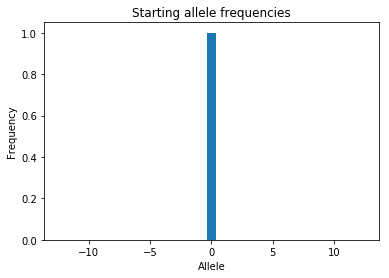

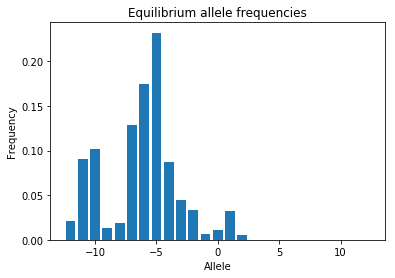

In [20]:
# Visualize an example
NUM_ALLELES = 25

# N_e is effective diploid population size
N_e = 500
THRESHOLD = 1/(2*N_e)

PARAM_beta = 0
PARAM_mu = 10e-3
PARAM_p = 0.9
PARAM_S = 0
PARAM_L = 0
PARAM_t = 50000 # Maximum number of iterations of while loop (prevent from running forever)

PARAM_is_w_additive = True # Whether the fitness matrix of genotypes is additive or multiplicative

# Set the starting vector of allele frequencies to be equal for all alleles
allele_freqs = np.zeros(NUM_ALLELES)
allele_freqs[int(NUM_ALLELES/2)] = 1.0

#for i in range(NUM_ALLELES):
#    allele_freqs[i] = 1/NUM_ALLELES
    
'''
# Another way to set starting vector of allele frequencies
allele_freqs[int(NUM_ALLELES/2)] = 0.98
allele_freqs[int(NUM_ALLELES/2)+1] = 0.01
allele_freqs[int(NUM_ALLELES/2)-1] = 0.01  
'''

# Visualize starting allele frequencies
fig = plt.figure()
ax = fig.add_subplot(111)
print("Starting allele frequencies")
print(allele_freqs)
ax.bar(list(range(-1*int(NUM_ALLELES/2), int(NUM_ALLELES/2)+1)), allele_freqs)
ax.set_title("Starting allele frequencies")
ax.set_xlabel("Allele")
ax.set_ylabel("Frequency");  
    
# Get transition matrix (constant)
transition_matrix = GetTransitionMatrix(NUM_ALLELES, PARAM_mu, PARAM_beta, PARAM_p, PARAM_L)

# Transpose transition matrix
transition_matrix_transpose = transition_matrix.transpose()
 
# Calculate fitness matrix for each allele pair (genotype)
fitness_matrix = GetFitnessMatrix(NUM_ALLELES, PARAM_S, PARAM_is_w_additive)

# Calculate marginal fitness w*(a[i]) for each allele
marginal_fitness_vector = GetMarginalFitnessVector(NUM_ALLELES, allele_freqs, fitness_matrix)

# Calculate gradient vector of partial derivatives of mean fitness
gradient = GetGradient(NUM_ALLELES, marginal_fitness_vector)
  
# Calculate mean fitness
mean_fitness = GetMeanFitness(NUM_ALLELES, allele_freqs, fitness_matrix)
    
# Calculate covariance matrix
covariance_matrix = GetCovarianceMatrix(NUM_ALLELES, allele_freqs)
    
# Save previous allele_freqs
allele_freqs_prev = copy.deepcopy(allele_freqs)

# Calculate new allele_freqs
# Applying selection
selection_vector = np.matmul(covariance_matrix, gradient)
    
for i in range(NUM_ALLELES):
    selection_vector[i] = selection_vector[i]/(2*mean_fitness)

allele_freqs = allele_freqs + selection_vector
   
# Applying mutation
allele_freqs = np.matmul(transition_matrix_transpose, allele_freqs)

# TODO: Also, probably only need to include all this code once in the while loop
# TODO: some numpy array operations will make things easier. like selection_vector/2*mean_fitness rather than a for loop
# Use multinomial sampling
allele_freqs = np.random.multinomial(2*N_e, allele_freqs)

# Rescale allele_freqs to sum to 1
rowsum = np.sum(allele_freqs)
   
new_allele_freqs = np.zeros(NUM_ALLELES)

for i in range(NUM_ALLELES):
    newVal = allele_freqs[i]/rowsum
    new_allele_freqs[i] = newVal

allele_freqs = new_allele_freqs
   
l_norm = GetLNorm(NUM_ALLELES, allele_freqs_prev, allele_freqs)

t = 0 # Number of iterations of while loop

while l_norm > THRESHOLD and t < PARAM_t:
    # Calculate fitness matrix for each allele pair (genotype)
    fitness_matrix = GetFitnessMatrix(NUM_ALLELES, PARAM_S, PARAM_is_w_additive)

    # Calculate marginal fitness w*(a[i]) for each allele
    marginal_fitness_vector = GetMarginalFitnessVector(NUM_ALLELES, allele_freqs, fitness_matrix)

    # Calculate gradient vector of partial derivatives of mean fitness
    gradient = GetGradient(NUM_ALLELES, marginal_fitness_vector)

    # Calculate mean fitness
    mean_fitness = GetMeanFitness(NUM_ALLELES, allele_freqs, fitness_matrix)

    # Calculate covariance matrix
    covariance_matrix = GetCovarianceMatrix(NUM_ALLELES, allele_freqs)

    # Save previous allele_freqs
    allele_freqs_prev = copy.deepcopy(allele_freqs)

    # Calculate new allele_freqs
    # Applying selection
    selection_vector = np.matmul(covariance_matrix, gradient)

    for i in range(NUM_ALLELES):
        selection_vector[i] = selection_vector[i]/(2*mean_fitness)
        
    allele_freqs = allele_freqs + selection_vector
    # Applying mutation, rescale
    allele_freqs = np.matmul(transition_matrix_transpose, allele_freqs)
    allele_freqs = [max(item, 0) for item in allele_freqs]
    rowsum = np.sum(allele_freqs)
    allele_freqs = [item/rowsum for item in allele_freqs]
    
    # Use multinomial sampling
    #print(allele_freqs)
    allele_freqs = np.random.multinomial(2*N_e, allele_freqs)
    
    # Rescale allele_freqs to sum to 1
    allele_freqs = [max(item, 0) for item in allele_freqs]
    rowsum = np.sum(allele_freqs)
    allele_freqs = [item/rowsum for item in allele_freqs]

    l_norm = GetLNorm(NUM_ALLELES, allele_freqs_prev, allele_freqs)
     
    t = t + 1
    
print("Number of iterations")
print(t)
    
#  Visualize equilibrium allele frequencies
fig = plt.figure()
ax = fig.add_subplot(111)
print("Equilibrium allele frequencies")
print(allele_freqs)
ax.bar(list(range(-1*int(NUM_ALLELES/2), int(NUM_ALLELES/2)+1)), allele_freqs)
ax.set_title("Equilibrium allele frequencies")
ax.set_xlabel("Allele")
ax.set_ylabel("Frequency");  